<a href="https://colab.research.google.com/github/afraa-n/XAI_in_LLMs/blob/main/XAI_LLMS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-25-69932d1bc7b8>:80: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label="Normalized Saliency Score", orientation="vertical", shrink=0.8)


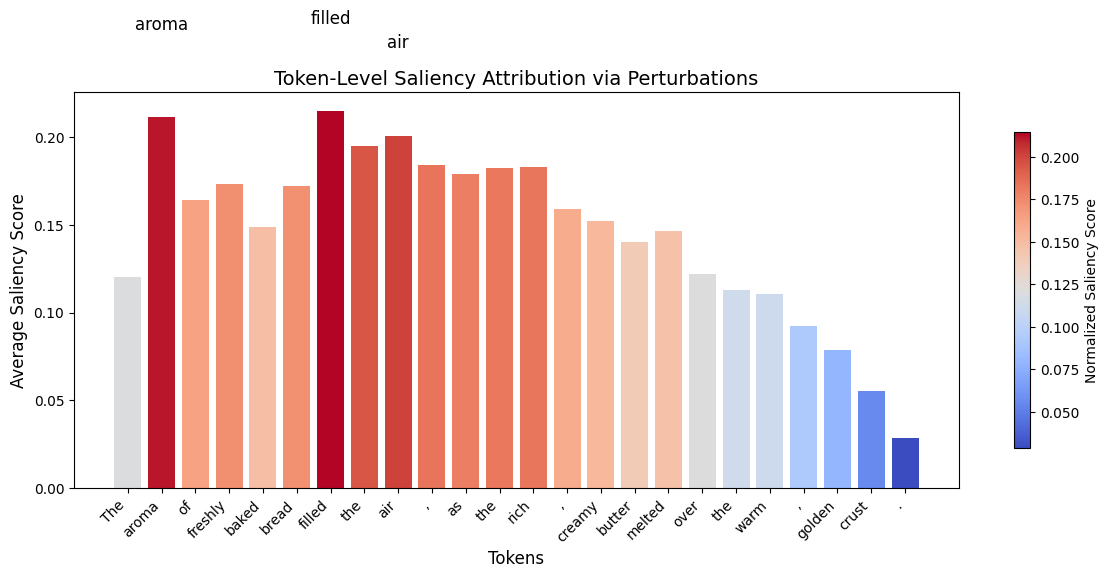

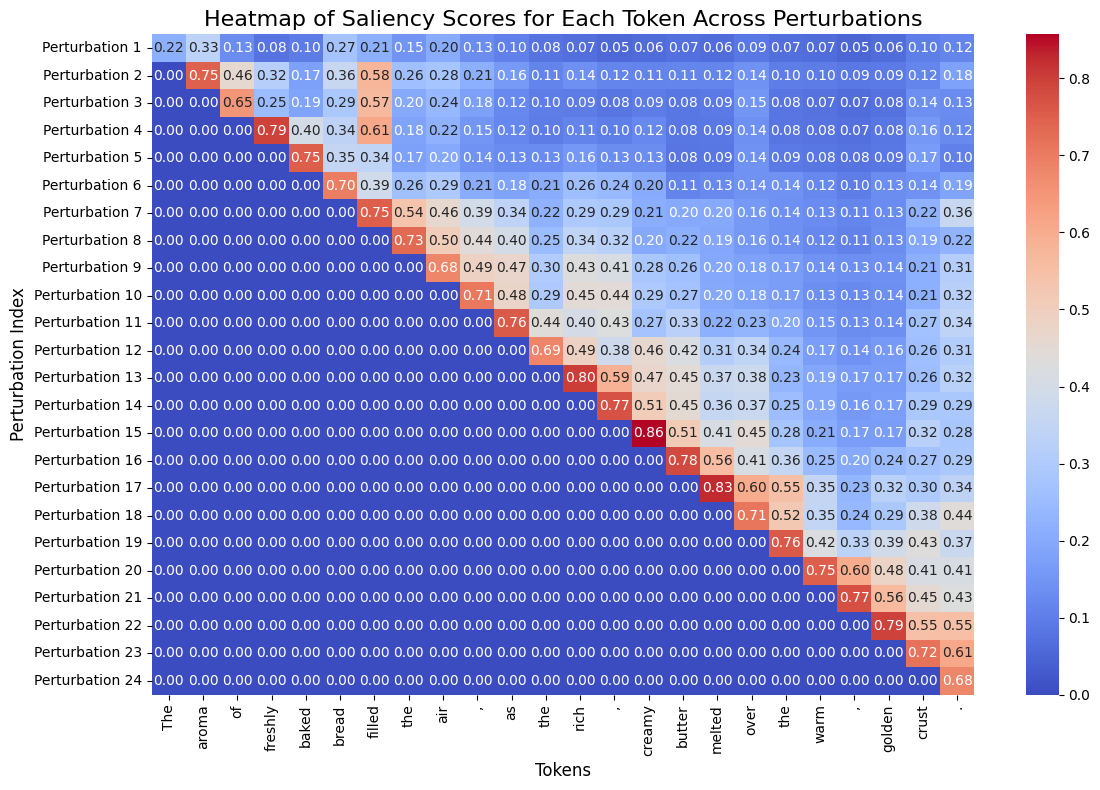

In [25]:
# Required Libraries
import torch
from transformers import GPT2Tokenizer, GPT2Model
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Initialize GPT-2 and Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2Model.from_pretrained("gpt2")
model.eval()  # Set model to evaluation mode

# Perturbation Analysis Function
def analyze_prompt_with_perturbations(prompt):
    # Tokenize input and get input embeddings
    inputs = tokenizer(prompt, return_tensors="pt")
    input_ids = inputs["input_ids"]

    # Get the number of tokens
    num_tokens = input_ids.shape[1]

    # Prepare a list to store saliency scores and perturbed scores
    saliency_scores = []

    for i in range(num_tokens):
        # Create a perturbed version of the input
        perturbed_ids = input_ids.clone()

        # Replace the token at index i with an irrelevant token (end of text token)
        perturbed_ids[0, i] = tokenizer.encode("<|endoftext|>")[0]

        with torch.no_grad():
            # Get embeddings for both original and perturbed inputs
            original_output = model(input_ids).last_hidden_state
            perturbed_output = model(perturbed_ids).last_hidden_state

            # Calculate the difference in the last hidden state
            saliency = (original_output - perturbed_output).abs().mean(dim=-1).squeeze(0)  # Mean absolute difference
            saliency_scores.append(saliency.numpy())

    # Convert saliency scores to a numpy array
    saliency_scores = np.array(saliency_scores)

    # Average saliency scores over all tokens
    avg_saliency_scores = saliency_scores.mean(axis=1)

    # Token Decoding (Removing Extra Characters)
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    tokens = [token.replace("Ġ", "") for token in tokens]  # Remove unwanted characters

    # Normalize saliency scores for color scaling
    norm_saliency = (avg_saliency_scores - np.min(avg_saliency_scores)) / (np.max(avg_saliency_scores) - np.min(avg_saliency_scores))

    # Return tokens, average saliency scores, and saliency scores for summary
    return tokens, avg_saliency_scores, saliency_scores, norm_saliency

# Food-Themed Prompt Example
prompt = "The aroma of freshly baked bread filled the air, as the rich, creamy butter melted over the warm, golden crust."
tokens, avg_attributions, saliency_scores, norm_saliency = analyze_prompt_with_perturbations(prompt)

# Improved Visualization: Bar Chart of Average Saliency Scores
plt.figure(figsize=(12, 6))
colors = sns.color_palette("coolwarm", as_cmap=True)(norm_saliency)

# Create a bar plot for average saliency scores
bars = plt.bar(range(len(tokens)), avg_attributions, color=colors)
plt.xticks(range(len(tokens)), tokens, rotation=45, ha='right', fontsize=10)
plt.xlabel("Tokens", fontsize=12)
plt.ylabel("Average Saliency Score", fontsize=12)
plt.title("Token-Level Saliency Attribution via Perturbations", fontsize=14)

# Highlight top 3 most important tokens
top_indices = np.argsort(avg_attributions)[-3:]
for i in top_indices:
    plt.text(i, avg_attributions[i] + 0.05, f"{tokens[i]}", ha='center', color="black", fontsize=12)

# Adding color bar for saliency gradient
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=plt.Normalize(vmin=np.min(avg_attributions), vmax=np.max(avg_attributions)))
sm.set_array([])
plt.colorbar(sm, label="Normalized Saliency Score", orientation="vertical", shrink=0.8)
plt.tight_layout()
plt.show()

# Additional Visualization: Heatmap of Saliency Scores
plt.figure(figsize=(12, 8))
sns.heatmap(saliency_scores, annot=True, fmt=".2f", cmap="coolwarm", xticklabels=tokens, yticklabels=[f"Perturbation {i+1}" for i in range(saliency_scores.shape[0])])
plt.title("Heatmap of Saliency Scores for Each Token Across Perturbations", fontsize=16)
plt.xlabel("Tokens", fontsize=12)
plt.ylabel("Perturbation Index", fontsize=12)
plt.tight_layout()
plt.show()